A robotic arm has two links with $L_1=1.2m$, and $L_2=0.8 m$. There is a 1 kg mass at the end of the second link. The joint’s friction and link mass are ignored. In the beginning, the joints are locked, and the mass is static

In [1]:
from sympy import symbols, cos, sin, sqrt, Matrix, simplify, atan, diff, atan2
from sympy import init_printing
import numpy 
from numpy import linspace, deg2rad, rad2deg, pi
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
# Variable initialization
theta1, theta2 = dynamicsymbols('theta1 theta2') 
L1, L2 = symbols('L1 L2')

# -DH Matrix-
def DH_matrix(alpha, a, d, theta):
    return Matrix([
        [cos(theta), -sin(theta), 0, a],
        [sin(theta)*cos(alpha), cos(theta)*cos(alpha), -sin(alpha), -sin(alpha)*d],
        [sin(theta)*sin(alpha), cos(theta)*sin(alpha), cos(alpha), cos(alpha)*d],
        [0, 0, 0, 1]
    ])

T03 = 


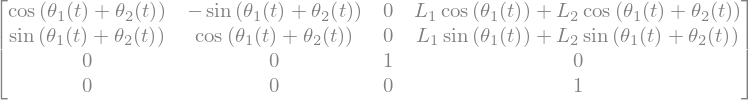

In [3]:
# Forward Kinematics
T01 = DH_matrix(0, 0, 0, theta1)
T12 = DH_matrix(0, L1, 0, theta2)
T23 = DH_matrix(0, L2, 0, 0)
T02 = T01 @ T12
T03 = T02 @ T23
T03 = simplify(T01 * T12 * T23)
print("T03 = ")
init_printing()
display(T03)

Jacobian J_L = 


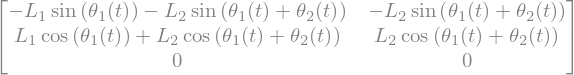

In [4]:
# ca1lculate Jacobian
# Linear Velocity Jacobian
Px = T03[0, 3]
Py = T03[1, 3]
Pz = T03[2, 3]
J_L = Matrix([
    [Px.diff(theta1), Px.diff(theta2)],
    [Py.diff(theta1), Py.diff(theta2)],
    [Pz.diff(theta1), Pz.diff(theta2)]
])
print("Jacobian J_L = ")
init_printing()
display(simplify(J_L))

R_dot =


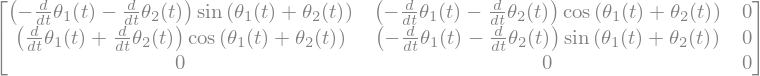

Omega = R_dot * R^T =


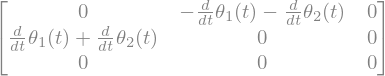

Angular velocity vector ω =


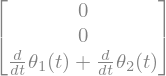

Angular Jacobian Jω =


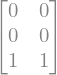

In [5]:
# Angular Velocity Jacobian
R01 = T01[0:3, 0:3]
R02 = T02[0:3, 0:3]
R03 = T03[0:3, 0:3]
R_dot = diff(R03, theta1)*diff(theta1) + diff(R03, theta2)*diff(theta2)
R_dot = simplify(R_dot)
print("R_dot =")
display(R_dot)
Omega = simplify(R_dot * R03.T)
print("Omega = R_dot * R^T =")
display(Omega)
omega = Matrix([
    Omega[2,1],
    Omega[0,2],
    Omega[1,0]
])
omega = simplify(omega)
print("Angular velocity vector ω =")
display(omega)
Jw = simplify(omega.jacobian([diff(theta1), diff(theta2)]))
print("Angular Jacobian Jω =")
display(Jw)

Total Jacobian J_total =


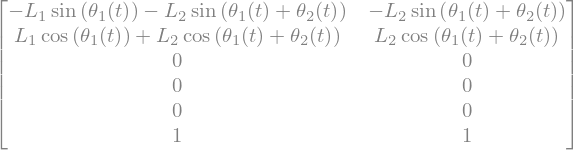

In [6]:
# Jacobian Matrix
J_total = J_L.col_join(Jw)
print("Total Jacobian J_total =")
display(simplify(J_total))

Then we need to find the velocity of the joint $\dot\theta_1%$ and $\dot\theta_2$ in $t = 0.6s$

Position of end-effector at time t = 0.6s:


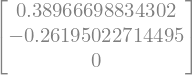

At time t = 0.6s, theta1 = -8.81 degrees, theta2 = 194.42 degrees


In [7]:
# Calculate joint velocities at t = 0.6s
# Given parameters
L1_val = 1.2
L2_val = 0.8
t = 0.6
m = 1 # kg
g = 9.81 # m/s^2
theta1_initial = deg2rad(45)
theta2_initial = deg2rad(80)
# Calculate the initial position of end-effector
T03_num = T03.subs({
    L1: L1_val,
    L2: L2_val,
    theta1: theta1_initial,
    theta2: theta2_initial
})
Px_num = T03_num[0, 3]
Py_num = T03_num[1, 3]
Pz_num = T03_num[2, 3]
# Calculate the position of end-effector at time t
Px_t = Px_num
Py_t = Py_num - 0.5 * g * t**2
Pz_t = Pz_num
# New position vector
P_end_effector_t = Matrix([Px_t, Py_t, Pz_t])
print("Position of end-effector at time t = 0.6s:")
display(P_end_effector_t)

# Calculate the velocity of the end-effector by newton second law
F = Matrix([0, -m*g, 0]) # Force vector
v_x = 0
V_y = -g * t
v_z = 0
v_end_effector = Matrix([v_x, V_y, v_z])
# Calculate theta 1 and theta 2
r2 = Px_t**2 + Py_t**2
c2 = -(L1_val**2 + L2_val**2 - r2) / (2*L1_val*L2_val)
if abs(c2) > 1.0:
    raise ValueError("Position is out of reach for the given link lengths.")
s2 = -sqrt(1 - c2**2)
theta2_t = atan2(s2, c2)
theta2_ccw = 2*pi + theta2_t
theta1_t = atan2(Py_t, Px_t) - atan2(L2_val * sin(theta2_t), L1_val + L2_val * cos(theta2_t))
print(f"At time t = {t}s, theta1 = {rad2deg(float(theta1_t)):.2f} degrees, theta2 = {rad2deg(float(theta2_ccw)):.2f} degrees")

Joint angular velocities at t = 0.6s:


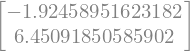

In [8]:
# Calculate joint angular velocities
J_total_num = J_total.subs({
    L1: L1_val,
    L2: L2_val,
    theta1: theta1_t,
    theta2: theta2_ccw
})
J = J_total_num[0:2, 0:2]
J_inv = J.inv()
joint_velocities = J_inv * v_end_effector[0:2, 0]
print("Joint angular velocities at t = 0.6s:")
display(simplify(joint_velocities))

Then we use Velocity propagation method

Angular Jacobian Jω =


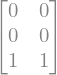

Linear Jacobian J_L =


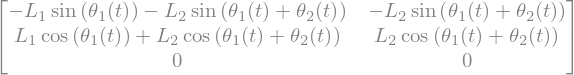

In [9]:
# Velocity Propagation method
P0in0 = Matrix([0, 0, 0])
P1in0 = P0in0
P2in0 = T02[0:3, 3]
P3in0 = T03[0:3, 3] 
P0_1_in0 = P1in0 - P0in0
P1_2_in0 = P2in0 - P1in0
P2_3_in0 = P3in0 - P2in0
z_0 = R01[:, 2]
z_1 = z_0
z_2 = R02[:, 2]
v0in0 = Matrix([0, 0, 0])
w0in0 = Matrix([0, 0, 0])
w1in0 = diff(theta1) * z_0
w2in0 = w1in0 + diff(theta2) * z_2
w3in0 = w2in0
v1in0 = v0in0 + w0in0.cross(P0_1_in0)
v2in0 = v1in0 + w1in0.cross(P1_2_in0)
v3in0_R = v2in0 + w2in0.cross(P2_3_in0)
# Angular velocity Jacobian
Jw = simplify(w3in0.jacobian([diff(theta1), diff(theta2)]))
print("Angular Jacobian Jω =")
display(Jw)
# Linear velocity Jacobian
Jl = simplify(v3in0_R.jacobian([diff(theta1), diff(theta2)]))
print("Linear Jacobian J_L =")
display(Jl)
